# Amplitude Rabi

This notebook shows you how to perform an amplitude Rabi oscillation experiment. You'll sweep the pulse amplitude of a qubit drive pulse to determine the ideal amplitudes for specific qubit rotation angles

## 0. LabOne Q Imports

You'll begin by importing `laboneq.simple` and some extra helper functions to run the examples. 

In [1]:
# LabOne Q:
from laboneq.simple import *

# Helpers:
from laboneq.contrib.example_helpers.data_analysis.data_analysis import (
    func_osc,
    fit_Rabi,
)
from laboneq.contrib.example_helpers.plotting.plot_helpers import (
    plot_results,
    plot_simulation,
)
from laboneq.contrib.example_helpers.generate_example_datastore import (
    generate_example_datastore,
    get_first_named_entry,
)

from pathlib import Path
import time

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Build an in-memory data store with device setup and qubit parameters for the
# example notebooks
setup_db = generate_example_datastore(in_memory=True)

## 1. Device Setup

Below, you'll create a device setup and specify to run in an emulated mode or on hardware, `emulate = True/False` respectively.

If you run on your hardware, the [descriptor](https://docs.zhinst.com/labone_q_user_manual/concepts/set_up_equipment.html) called by `create_device_setup` should be replaced by one of your own, generally stored as a [YAML file](https://docs.zhinst.com/labone_q_user_manual/concepts/set_up_equipment.html#labone_q.func_concepts.setting_up.set_up_equipment.descriptor). Once you have this descriptor, it can be reused for all your experiments.

In [3]:
# load a calibrated device setup from the dummy database
device_setup = get_first_named_entry(
    db=setup_db, name="6_qubit_setup_shfsg_shfqa_hdawg_pqsc_calibrated"
)

emulate = True

In [4]:
# create and connect to a session
session = Session(device_setup=device_setup)
session.connect(do_emulation=emulate)

2023.08.16 15:19:20.902 laboneq.controller.laboneq_logging INFO   Logging initialized from [Default inline config in laboneq.controller.laboneq_logging] logdir is /Users/clemensm/Zurich Instruments/CodeRepos/LabOneQ/examples/01_qubit_characterization/laboneq_output/log
2023.08.16 15:19:20.904 laboneq.controller.controller  INFO   VERSION: laboneq 1.0+local
2023.08.16 15:19:20.905 laboneq.controller.devices.device_collection INFO   Connecting to data server at localhost:8004
2023.08.16 15:19:20.906 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
2023.08.16 15:19:20.910 laboneq.controller.devices.device_collection INFO   Configuring the device setup
2023.08.16 15:19:20.916 laboneq.controller.devices.device_collection INFO   The device setup is configured


## 2. Experiment Parameters

Now you'll define the amplitude sweep parameters and pulses to use in your experiment.

In [5]:
# range of pulse amplitude scan
def create_rabi_amp_sweep(amp_num, uid="rabi_amp"):
    amp_min = 0
    amp_max = 1
    return LinearSweepParameter(uid=uid, start=amp_min, stop=amp_max, count=amp_num)


# define number of averages
# used for 2^num_averages, maximum: num_averages = 17
num_averages = 4


# pulse parameters and definitions
envelope_duration = 2.0e-6
sigma = 0.2
flat_duration = 1.0e-6


def create_readout_pulse(
    qubit, length=envelope_duration, amplitude=0.9, width=flat_duration, sigma=sigma
):
    readout_pulse = pulse_library.gaussian_square(
        uid=f"readout_pulse_{qubit}",
        length=length,
        amplitude=amplitude,
        width=width,
        sigma=sigma,
    )
    return readout_pulse


def create_rabi_drive_pulse(qubit, length=1e-6, amplitude=0.9):
    return pulse_library.gaussian(
        uid=f"gaussian_drive_q{qubit}", length=length, amplitude=amplitude
    )

## 3. Experiment Definition

You'll now create a function which generates an [experiment](https://docs.zhinst.com/labone_q_user_manual/concepts/experiment.html). In this experiment, you'll pass an amplitude sweep parameter as an argument to the [sweep section](https://docs.zhinst.com/labone_q_user_manual/concepts/averaging_sweeping.html#labone_q.func_concepts.experiment.averaging_sweeping.parameters_sweeps). Within the sweeep section, you'll create another [section](https://docs.zhinst.com/labone_q_user_manual/concepts/sections_and_pulses.html) containing a `play` command to drive the qubit, where the amplitude of this command takes the sweep parameter. You'll also make a readout section containing `play` and `acquire` commands to perform readout. Within the real-time acquisition section, you'll set use `INTEGRATION` as your acquisition type.

In [6]:
# function that returns an amplitude Rabi experiment
def amplitude_rabi(drive_pulse, readout_pulse, amplitude_sweep):
    exp_rabi = Experiment(
        uid="Amplitude Rabi",
        signals=[
            ExperimentSignal("drive"),
            ExperimentSignal("measure"),
            ExperimentSignal("acquire"),
        ],
    )

    ## define Rabi experiment pulse sequence
    # outer loop - real-time, cyclic averaging
    with exp_rabi.acquire_loop_rt(
        uid="rabi_shots",
        count=num_averages,
        averaging_mode=AveragingMode.CYCLIC,
        acquisition_type=AcquisitionType.INTEGRATION,
    ):
        # inner loop - real time sweep of Rabi ampitudes
        with exp_rabi.sweep(uid="rabi_sweep", parameter=amplitude_sweep):
            # play qubit excitation pulse - pulse amplitude is swept
            with exp_rabi.section(
                uid="qubit_excitation", alignment=SectionAlignment.RIGHT
            ):
                exp_rabi.play(
                    signal="drive", pulse=drive_pulse, amplitude=amplitude_sweep
                )
            # readout pulse and data acquisition
            with exp_rabi.section(uid="readout_section", play_after="qubit_excitation"):
                # play readout pulse on measure line
                exp_rabi.play(signal="measure", pulse=readout_pulse)
                # trigger signal data acquisition
                exp_rabi.acquire(
                    signal="acquire",
                    handle="amp_rabi",
                    kernel=readout_pulse,
                )
            with exp_rabi.section(uid="delay", length=1e-6):
                # relax time after readout - for qubit relaxation to groundstate and signal processing
                exp_rabi.reserve(signal="measure")
    return exp_rabi

### 3.1 Create Experiment and Signal Map

Before running the experiment, you'll define and set the mapping between the experimental and logical lines.

In [7]:
# define pulses and create experiment
readout_pulse = create_readout_pulse("q0")
drive_pulse = create_rabi_drive_pulse("q0")
exp_rabi = amplitude_rabi(drive_pulse, readout_pulse, create_rabi_amp_sweep(amp_num=61))


# signal map for qubit 0
def signal_map_default(qubit):
    signal_map = {
        "drive": device_setup.logical_signal_groups[f"{qubit}"].logical_signals[
            "drive_line"
        ],
        "measure": device_setup.logical_signal_groups[f"{qubit}"].logical_signals[
            "measure_line"
        ],
        "acquire": device_setup.logical_signal_groups[f"{qubit}"].logical_signals[
            "acquire_line"
        ],
    }
    return signal_map


# run the experiment on qubit 0
exp_rabi.set_signal_map(signal_map_default("q0"))

### 3.2 Compile, Generate Pulse Sheet, and Plot Simulated Signals

Now, you'll compile the experiment and generate a pulse sheet.

In [8]:
# compile the experiment on the open instrument session
compiled_rabi = session.compile(exp_rabi)

Path("Pulse_Sheets").mkdir(parents=True, exist_ok=True)
# generate a pulse sheet to inspect experiment before runtime
show_pulse_sheet("Pulse_Sheets/Rabi", compiled_rabi)

2023.08.16 15:19:20.942 laboneq.compiler.workflow.compiler INFO   Starting LabOne Q Compiler run...
2023.08.16 15:19:20.949 laboneq.compiler.scheduler.scheduler INFO   Schedule completed
2023.08.16 15:19:20.975 laboneq.compiler.workflow.compiler INFO   Total seqC lines generated: 143
2023.08.16 15:19:20.977 laboneq.compiler.workflow.compiler INFO   Total sample points generated: 16000
2023.08.16 15:19:20.978 laboneq.compiler.workflow.compiler INFO   Finished LabOne Q Compiler run.
2023.08.16 15:19:20.979 laboneq.compiler.workflow.compiler INFO   Starting LabOne Q Compiler run...
2023.08.16 15:19:20.984 laboneq.compiler.scheduler.scheduler INFO   Schedule completed
2023.08.16 15:19:21.009 laboneq.compiler.workflow.compiler INFO   Total seqC lines generated: 143
2023.08.16 15:19:21.009 laboneq.compiler.workflow.compiler INFO   Total sample points generated: 16000
2023.08.16 15:19:21.009 laboneq.compiler.workflow.compiler INFO   Finished LabOne Q Compiler run.
2023.08.16 15:19:21.150 labo

/Users/clemensm/Zurich Instruments/CodeRepos/LabOneQ/examples/01_qubit_characterization/Pulse_Sheets/Rabi_2023-08-16-15-19-20.html

In addition to creating a pulse sheet to inspect the timing of pulses, you can simulate physical output of the channels.

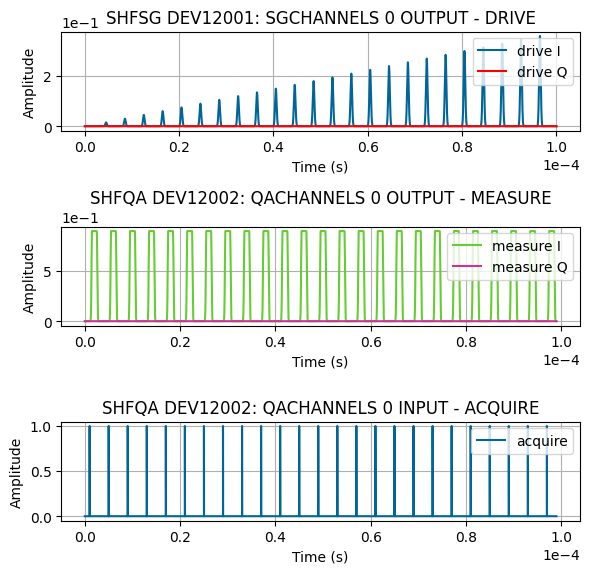

In [9]:
plot_simulation(compiled_rabi, start_time=0, length=100e-6)

### 3.3 Run, Save, and Plot Results

Finally, you'll run the experiment, save, and plot the results.

In [10]:
# run the compiled experiemnt
rabi_results = session.run()
timestamp = time.strftime("%Y%m%dT%H%M%S")
Path("Results").mkdir(parents=True, exist_ok=True)
session.save_results(f"Results/{timestamp}_rabi_results.json")
print(f"File saved as Results/{timestamp}_rabi_results.json")

2023.08.16 15:19:21.618 laboneq.controller.util        CRITICAL SHFSG:dev12001: Local oscillator for channel 0 is required, but is not provided.


2023.08.16 15:19:21.618 laboneq.controller.util        CRITICAL SHFSG:dev12001: Local oscillator for channel 0 is required, but is not provided.


LabOneQControllerException: SHFSG:dev12001: Local oscillator for channel 0 is required, but is not provided.

In [ ]:
plot_results(rabi_results)

# 4. Fitting Results

You can also fit your results. The below script fits some emulated Rabi data when running in emulation mode.

In [ ]:
# get measurement data returned by the instruments
rabi_res = rabi_results.get_data("amp_rabi")

# define amplitude axis from qubit parameters
rabi_amp = rabi_results.get_axis("amp_rabi")[0]

if emulate:
    # create some dummy data if running in emulation mode
    rabi_res = func_osc(rabi_amp, 10, 0, 1, 1.2) + 0.2 * np.random.rand(len(rabi_amp))

# plot measurement data
fig = plt.figure()
plt.plot(rabi_amp, rabi_res, ".k")
plt.ylabel("A (a.u.)")
plt.xlabel("amplitude (a.u.)")

# increase number of plot points for smooth plotting of fit results
amp_plot = np.linspace(rabi_amp[0], rabi_amp[-1], 5 * len(rabi_amp))

# fit measurement results - assume sinusoidal oscillation with drive amplitude
popt, pcov = fit_Rabi(rabi_amp, rabi_res, 10, 0, 1, 1.2, plot=False)
print(popt)

# plot fit results together with measurement data
plt.plot(amp_plot, func_osc(amp_plot, *popt), "-r")